In [1]:
import pandas as pd
import numpy as np
import scipy.signal
from sys import getsizeof
import matplotlib.pyplot as plt
import re 

In [2]:
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.models import Sequential, Model, clone_model
from keras.utils import np_utils
from keras.utils import to_categorical

Using TensorFlow backend.


## try CNN model using 1D data

In [3]:
class StockData():
    def __init__(self, file_path):
        
        data = pd.read_csv(file_path, header=0, index_col=0) 
        y = data['label'] 
        X = data.drop(['symbol', 'label'], axis = 1)
        
        X_train_valid_w_rtn, X_test_w_rtn, y_train_valid, y_test = train_test_split(X, y, test_size=0.25) 
        
        # balance the train_valid data set
        balance_data_set = True
        if balance_data_set:
            df = pd.concat([X_train_valid_w_rtn, y_train_valid], axis=1)
            tmp_pos = df[df['rtn'] > 0] 
            tmp_neg = df[df['rtn'] < 0] 
            if tmp_pos.shape[0] > tmp_neg.shape[0]: 
                tmp_pos = tmp_pos.sample(tmp_neg.shape[0])
            elif tmp_pos.shape[0] < tmp_neg.shape[0]:
                tmp_neg = tmp_neg.sample(tmp_pos.shape[0])
            df = pd.concat([tmp_pos, tmp_neg], axis = 0)
            y_train_valid = df['label']
            X_train_valid_w_rtn = df.drop(['label'], axis = 1)
        
        X_train_w_rtn, X_valid_w_rtn, y_train, y_valid = train_test_split(X_train_valid_w_rtn, y_train_valid, test_size=0.33) 
        # train_valid set
        self.train_valid_rtn = X_train_valid_w_rtn['rtn']
        self.X_train_valid = X_train_valid_w_rtn.drop(['rtn'], axis = 1)
        self.y_train_valid = y_train_valid
        # train set 
        self.train_rtn = X_train_w_rtn['rtn'] 
        self.X_train = X_train_w_rtn.drop(['rtn'], axis = 1)
        self.y_train = y_train
        # valid set
        self.valid_rtn = X_valid_w_rtn['rtn']
        self.X_valid = X_valid_w_rtn.drop(['rtn'], axis = 1) 
        self.y_valid = y_valid
        # test set 
        self.test_rtn = X_test_w_rtn['rtn']
        self.X_test = X_test_w_rtn.drop(['rtn'], axis = 1)        
        self.y_test = y_test 

In [4]:
data = StockData('../data/D1over5.csv') 

In [5]:
data.X_train.shape

(40221, 123)

In [9]:
X_train = np.array(data.X_train).reshape(data.X_train.shape[0], 3, 41)
y_train = to_categorical(data.y_train)
X_valid = np.array(data.X_valid).reshape(data.X_valid.shape[0], 3, 41)
y_valid = to_categorical(data.y_valid)

In [10]:
X_train = np.transpose(X_train, (0, 2, 1))
X_valid = np.transpose(X_valid, (0, 2, 1))

In [11]:
model = Sequential()
model.add(Conv1D(6, kernel_size=3, input_shape=(41,3), padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(6, kernel_size=3, padding='same', activation='sigmoid'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(12, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_valid, y_valid))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 40221 samples, validate on 19811 samples
Epoch 1/20
40221/40221 [==============================] - 5s 127us/step - loss: 0.6940 - acc: 0.4998 - val_loss: 0.6932 - val_acc: 0.5044
Epoch 2/20
40221/40221 [==============================] - 4s 108us/step - loss: 0.6937 - acc: 0.5045 - val_loss: 0.6930 - val_acc: 0.5007
Epoch 3/20
40221/40221 [==============================] - 4s 108us/step - loss: 0.6935 - acc: 0.5029 - val_loss: 0.6942 - val_acc: 0.4979
Epoch 4/20
40221/40221 [==============================] - 5s 114us/step - loss: 0.6932 - acc: 0.5067 - val_loss: 0.6930 - val_acc: 0.5058
Epoch 5/20
40221/40221 [==============================] - 5s 115us/step - loss: 0.6933 - acc: 0.5036 - val_loss: 0.6943 - val_acc: 0.4983
Epoch 6/20
40221/40221 [==============================] - 5s 119us/step - loss: 0.6934 - acc: 0.5012 - val_loss: 0.6933 - val_acc: 0.5021
Ep

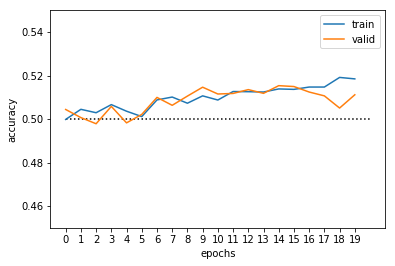

In [13]:
# results using training set and valid set 
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.hlines(0.5, 0, 20, linestyles='dotted')
plt.ylim(0.45, 0.55)
plt.xticks(range(0, 20))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train', 'valid']);

In [0]:
scores = model.evaluate(X_test, y_test, verbose=1)
# print("CNN Error: %.2f%%" % (100-scores[1]*100))
scores

24008/24008 [==============================] - 1s 45us/step


[0.6928916012037202, 0.508622125958014]

In [0]:
sum(data.y_test)/data.y_test.shape[0]

0.41152949016994333

In [0]:
pred = model.predict(X_test)

In [0]:
pred_probs = pd.Series(pred[:, 1], name = "pred_probs")
results = pd.concat([pred_probs, data.y_test.reset_index(drop = True)], axis = 1)

In [0]:
results['pred_prob_level'] = [int(x * 20)/20 for x in results['pred_probs']]

In [0]:
summary = pd.concat([results.groupby(['pred_prob_level']).mean(), 
                     results.groupby(['pred_prob_level']).count()['label'], 
                     100 * results.groupby(['pred_prob_level']).count()['label']/results.shape[0]], 
                    axis = 1)
summary.columns = ['predicted win prob', 'actual win rate', '# of trades', '% of all trades']
summary

,predicted win prob,actual win rate,# of trades,% of all trades
pred_prob_level,,,,
0.40,0.446339,0.277778,18,0.074975
0.45,0.487971,0.401275,11765,49.004499
0.50,0.512105,0.421734,12202,50.824725
0.55,0.554172,0.347826,23,0.095801
